In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os
import optuna
import shap

In [2]:
# Construct the path to the CSV file
csv_file_path = "../Data/proj_4_feat_target_var_set.csv"

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Check the data
print(df.head())

   fips_code state_id  state_name  high_tourist_border_sales  year  \
0          1       AL     Alabama                          0  2010   
1          2       AK      Alaska                          1  2010   
2          4       AZ     Arizona                          0  2010   
3          5       AR    Arkansas                          0  2010   
4          6       CA  California                          0  2010   

   niaaa_pop_21_plus  census_total_pop  census_total_pop_21_plus  \
0            3439923           4785298                   3426273   
1             494781            713985                    494078   
2            4496526           6413737                   4502443   
3            2082760           2921606                   2074340   
4           26311028          37349363                  26293952   

   census_percent_pop_21_plus  census_percent_pop_18_24  ...  \
0                       0.716                     0.102  ...   
1                       0.692             

In [3]:
# Specify feature names and types
numerical_features = ['tpc_state_beer_tax_rates_dollar_gal','bea_personal_income_dollars','bea_disp_inc_dollars',	'bea_percapita_personal_income_dollars', 'bea_percapita_disp_inc_dollars',
                      'census_median_household_inc_dollars'] 
percentage_features = ['census_percent_pop_21_plus','census_percent_pop_18_24','census_percent_pop_25_34','census_percent_pop_35_44','census_percent_pop_45_54', 
                       'census_percent_pop_55_64', 'census_percent_pop_65_plus','census_percent_pop_male', 'census_percent_pop_female', 'census_percent_pop_married', 'census_percent_pop_widowed',	
                       'census_percent_pop_divorced','census_percent_pop_separated','census_percent_pop_never_married',	'ed_census_percent_pop_less_hs', 'ed_census_percent_pop_only_hs', 
                       'ed_census_percent_pop_some_college_or_assoc','ed_percent_pop_college_grad_only','ed_percent_pop_grad_prof_degree', 'census_percent_employed', 'census_percent_unemployed',
                       'census_percent_armed_forces_employment', 'census_percent_not_in_labor_force','brfss_drinking_culture_surrogate_metric_percent_binge', 'census_percent_pop_in_poverty_est']
binary_features = ['high_tourist_border_sales']
target_column = 'niaaa_legal_adult_per_capita_beer_consumed_gallons'

In [4]:
# Set X and y variables from the DataFrame
X = df[numerical_features + percentage_features + binary_features]
y = df[target_column]

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('pct', MinMaxScaler(), percentage_features),
        ('cat', 'passthrough', binary_features)
    ],
    remainder='passthrough'  # This ensures any unspecified columns are passed through
)

# Define a function that creates a pipeline with given hyperparameters
def create_pipeline(n_estimators, learning_rate, max_depth, subsample, colsample_bytree):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42))
    ])
    return pipeline

# Define function for testing hyperparameters in the XGBoost regression model
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 9)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    
    pipeline = create_pipeline(n_estimators, learning_rate, max_depth, subsample, colsample_bytree)
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print results every 10 trials, adjusting for human-readable trial numbering
    if (trial.number + 1) % 10 == 0:
        print(f"Trial {trial.number + 1}, MSE: {mse}, R2: {r2}")
    
    return mse

In [6]:
# Adjust Optuna's logging level to suppress informational messages
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run the hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

print("Best Parameters:", study.best_params)
print("Best Mean Squared Error:", study.best_value)

Trial 10, MSE: 2.0386778779586536, R2: 0.9343537169278987
Trial 20, MSE: 7.559016729539925, R2: 0.7565964896470068
Trial 30, MSE: 2.760208119922375, R2: 0.9111201403922765
Trial 40, MSE: 2.927450146469939, R2: 0.9057348769649387
Trial 50, MSE: 2.3772430725420954, R2: 0.9234517756049074
Trial 60, MSE: 3.672697899365031, R2: 0.8817375866257776
Trial 70, MSE: 2.697663925869943, R2: 0.9131340896834679
Trial 80, MSE: 2.1692602833622523, R2: 0.9301489086832808
Trial 90, MSE: 2.261685244843721, R2: 0.9271727861433061
Trial 100, MSE: 2.434613545849799, R2: 0.9216044222925199
Trial 110, MSE: 2.135271143589428, R2: 0.931243373245352
Trial 120, MSE: 1.9624863597415743, R2: 0.9368071157834255
Trial 130, MSE: 3.0389849498643184, R2: 0.9021434094971356
Trial 140, MSE: 28.521514333457763, R2: 0.08159527121864629
Trial 150, MSE: 2.501023478569695, R2: 0.9194659945942242
Trial 160, MSE: 2.414286493245835, R2: 0.9222589619153256
Trial 170, MSE: 2.569805075847009, R2: 0.9172511983020611
Trial 180, MSE: 2

In [7]:
# To apply the best parameters, use the create_pipeline function with the best parameters found
best_pipeline = create_pipeline(**study.best_params)
best_pipeline.fit(X_train, y_train)

# Use the best pipeline to make predictions on the test set
y_pred = best_pipeline.predict(X_test)

# Calculate MSE and R2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the MSE and R2 score
print(f"Mean Squared Error (MSE) on Test Set: {mse}")
print(f"R^2 Score on Test Set: {r2}")

Mean Squared Error (MSE) on Test Set: 1.7404385489495673
R^2 Score on Test Set: 0.9439571484592046


In [8]:
# Getting feature importances
feature_importances = best_pipeline.named_steps['regressor'].feature_importances_
transformed_feature_names = numerical_features + percentage_features + binary_features
importances_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importances_df)

Feature Importances:
                                              Feature  Importance
11                           census_percent_pop_55_64    0.117002
31                          high_tourist_border_sales    0.107924
2                                bea_disp_inc_dollars    0.064277
29  brfss_drinking_culture_surrogate_metric_percen...    0.057533
24                    ed_percent_pop_grad_prof_degree    0.056343
1                         bea_personal_income_dollars    0.053360
23                   ed_percent_pop_college_grad_only    0.044074
0                 tpc_state_beer_tax_rates_dollar_gal    0.042756
16                         census_percent_pop_widowed    0.040842
14                          census_percent_pop_female    0.036819
6                          census_percent_pop_21_plus    0.035765
19                   census_percent_pop_never_married    0.035608
15                         census_percent_pop_married    0.033514
20                      ed_census_percent_pop_less_hs  

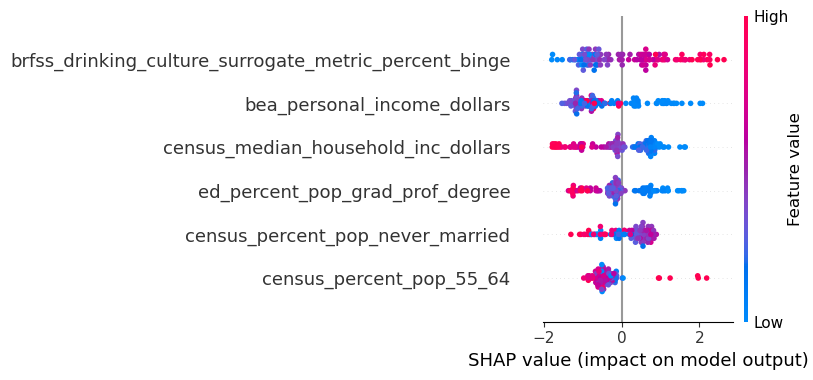

In [9]:
# Transform the datasets and create DataFrames with correct feature names
transformed_feature_names = numerical_features + percentage_features + binary_features

X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)

# Convert the transformed data back to DataFrames to retain feature names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)

# Initialize the SHAP Explainer with the model using the DataFrame (which includes feature names)
explainer = shap.Explainer(best_pipeline.named_steps['regressor'], X_train_transformed_df)

# Calculate SHAP values for the test set transformed DataFrame
shap_values = explainer(X_test_transformed_df)

# Summary plot with correct feature names
shap_features = 6
shap.summary_plot(shap_values, X_test_transformed_df, max_display = shap_features, feature_names=transformed_feature_names)